# Data exploration and visualization for the soil metagenomes (DP1.10107.001) NEON study  

This notebook explores how soil pH changes with time for the 47 sites part of the NEON study. It also examines how the average water_content changes by season for each site.

In [1]:
import requests

import pandas as pd
import folium
import altair as alt
from altair import Chart
from datetime import datetime

import pprint

import matplotlib.pyplot as plt
import numpy as np

### Get the Study ID for the NEON soil metagenome DP1.10107.001 project

Using the python requests library, and the [NMDC studies find endpoint](https://api.microbiomedata.org/docs#/find/find_studies_studies_get), we can get the NMDC study ID to filter by. More information regarding the API can be found [here](https://github.com/microbiomedata/NMDC_documentation/blob/main/docs/howto_guides/api_gui.md)

In [2]:
base_url = "https://api.microbiomedata.org"
filt = "name.search:DP1.10107.001"
url = f"{base_url}/studies?filter={filt}"
resp = requests.get(url)
studies = resp.json()["results"]
study_id = []
for study in studies:
    study_id.append(study["id"])
# Since there is only one value in the results, convert list to a string
study = "".join(study_id)
print(f"{study =}")

study ='nmdc:sty-11-34xj1150'


### Get all the biosamples associated with the NEON soil metagenomes study by the NMDC study ID

We can use the NMDC study ID obtained above, and the [NMDC biosamples find endpoint](https://api.microbiomedata.org/docs#/find/find_biosamples_biosamples_get) to filter the biosamples in the data portal by the study they are `part_of`. We can limit the results by the fields we would like returned, such as `ph`, `water_content`, etc. Cursor pagination is used to request a large amount of information - only 2000 results `per_page` are allowed. Here the total number of biosamples associated with the NEON study is printed. A list of all the results (`all_results`) is created.

In [3]:
# Specify the number of results per_page, the desired fields to be returned, the filter method, and cursor pagination
per_page = 2000
fields = "ph,collection_date.has_raw_value,env_medium,geo_loc_name,lat_lon,water_content,soil_horizon,elev"
filt = f"part_of:{study}"
cursor = "*"
all_results = []


# Use cursor pagination to get results
while True:
    url = f"{base_url}/biosamples?filter={filt}&per_page={per_page}&cursor={cursor}&fields={fields}"
    resp = requests.get(url)
    data = resp.json()
    results = data["results"]
    cursor = data["meta"]["next_cursor"]
    all_results.extend(results)
    if not cursor:
        break

print(f"Total number of biosamples: {len(all_results)}")

Total number of biosamples: 4475


### Geo-location and collection date exploration

Using the returned results, we can explore the number of locations, or sites, in the data using the `geo_location` field (aka slot) and the `lat_lon` field, as well as the number of collection dates using the `collection_date` field. Here, we print the number of distinct coordinates, geo_locations, and dates.

In [4]:
# Find total number of NEON coordinates
# Find the total number of geo locations (equivalent to NEON sites)
# Find the total  number of collection dates

# Initialize empty sets for coordinates, geo locations, and dates
coordinates = set()
geo_locs = set()
dates = set()

# Initialize a dictionary to log IDs of samps missing certain data
missing_data_log = {
    'missing_lat_lon': [],
    'missing_geo_loc_name': [],
}

for samp in all_results:
    samp_id = samp.get('id', 'Unknown ID')  # Assuming each samp has an 'id' key
    
    # Check and log if 'lat_lon' data is missing
    try:
        lat_lon = f"{samp['lat_lon']['latitude']},{samp['lat_lon']['longitude']}"
        coordinates.add(lat_lon)
    except KeyError:
        missing_data_log['missing_lat_lon'].append(samp_id)
    
    # Check and log if 'geo_loc_name' data is missing
    try:
        geo_loc = samp["geo_loc_name"]["has_raw_value"]
        geo_locs.add(geo_loc)
    except KeyError:
        missing_data_log['missing_geo_loc_name'].append(samp_id)
    
    # Proceed with collection date as usual
    try:
        collection_date = samp["collection_date"]["has_raw_value"]
        dates.add(collection_date)
    except KeyError:
        pass  # Assuming you're not logging missing dates based on your previous instructions



In [5]:
print(f"Number of NEON coordinates: {len(coordinates)}")
print(f"Number of geo locations (sites): {len(geo_locs)}")
print(f"Number of dates: {len(dates)}")

Number of NEON coordinates: 495
Number of geo locations (sites): 47
Number of dates: 4242


### Print the missing data log

In [6]:
pprint.pprint(missing_data_log)

{'missing_geo_loc_name': ['nmdc:bsm-11-06ccvh28',
                          'nmdc:bsm-11-106c8d05',
                          'nmdc:bsm-11-2zwg9712',
                          'nmdc:bsm-11-4x2qkj21',
                          'nmdc:bsm-11-7kpxhm28',
                          'nmdc:bsm-11-8787zw41',
                          'nmdc:bsm-11-8cxnkr78',
                          'nmdc:bsm-11-8sd8fz91',
                          'nmdc:bsm-11-axp5c220',
                          'nmdc:bsm-11-b110zv53',
                          'nmdc:bsm-11-c7daje72',
                          'nmdc:bsm-11-crbr4c98',
                          'nmdc:bsm-11-dx4vst02',
                          'nmdc:bsm-11-e58tq797',
                          'nmdc:bsm-11-egg5r069',
                          'nmdc:bsm-11-jegtqt43',
                          'nmdc:bsm-11-jpjz1v45',
                          'nmdc:bsm-11-kczbxa81',
                          'nmdc:bsm-11-ncna5c73',
                          'nmdc:bsm-11-nmwj8k60',


### Print a returned result

Let's print the first returned result to see what the requested data looks like.

In [7]:
pprint.pprint(all_results[0])

{'collection_date': {'has_raw_value': '2016-07-26T01:30Z'},
 'elev': 677.6,
 'env_medium': {'term': {'id': 'ENVO:00001998', 'name': 'soil'}},
 'geo_loc_name': {'has_raw_value': 'USA: Alaska, Healy'},
 'id': 'nmdc:bsm-11-002vgm56',
 'lat_lon': {'latitude': 63.875088, 'longitude': -149.210438},
 'ph': 6.04,
 'soil_horizon': 'O horizon',
 'water_content': ['2.667 g of water/g of dry soil']}


### Convert results to a data frame and transform into desired format
We can use the pandas python library to convert the requested results into a data frame. By looping through the results, we can update the data types for the fields (e.g. convert `collection_date` to a date using the datetime library and drop the times) and create a dictionary where the keys are the columns and the values are the results we are looping through, appending the dictionary to an initially empty list (`df_inp`). This allows for easy conversion to a data frame.

In [8]:
# Convert results to dataframes
# Transform results to desired format and convert to a data frame
df_inp = []
water_content_units = "g of water/g of dry soil"

for biosamp in all_results:
    # Reset variables
    water_content = None
    ph = None

    # Initialize record with default values
    rec = {
        "id": biosamp.get("id"),
        "collection_date": None,
        "soil_horizon": biosamp.get("soil_horizon"),
        "water_content": water_content,
        "ph": ph,
        "elev": None,
        "location": None,
        "latitude": None,
        "longitude": None,
    }

    # Get only month, day, and year from collection_date (remove times)
    try:
        date_str = biosamp["collection_date"]["has_raw_value"]
        date = datetime.strptime(date_str, "%Y-%m-%dT%H:%MZ")
        rec["collection_date"] = date.strftime("%Y-%m-%d")
    except KeyError:
        pass

    # Extract out units of water_content and convert to float
    # Handle water_content when it's a list
    try:
        if 'water_content' in biosamp:
            # Assuming the list contains strings and we're looking for the first element
            water_content_list = biosamp["water_content"]
            if water_content_list:
                # Convert the first list element to string and remove units
                water_content_str = water_content_list[0].replace("g of water/g of dry soil", "").strip()
                rec["water_content"] = float(water_content_str)
    except ValueError:
        pass

    # Convert pH to float, if present
    rec["ph"] = float(biosamp["ph"]) if "ph" in biosamp else None

    # Extract elevation, location, and lat_lon
    try:
        rec["elev"] = float(biosamp["elev"])
    except (KeyError, ValueError):
        pass

    try:
        rec["location"] = biosamp["geo_loc_name"]["has_raw_value"]
    except KeyError:
        pass

    try:
        rec["latitude"] = biosamp["lat_lon"]["latitude"]
        rec["longitude"] = biosamp["lat_lon"]["longitude"]
    except KeyError:
        pass

    df_inp.append(rec)

df = pd.DataFrame(df_inp)

df 

,id,collection_date,soil_horizon,water_content,ph,elev,location,latitude,longitude
0,nmdc:bsm-11-002vgm56,2016-07-26,O horizon,2.667,6.04,677.6,"USA: Alaska, Healy",63.875088,-149.210438
1,nmdc:bsm-11-00dkyf35,2019-03-13,M horizon,0.113,6.65,381.8,"USA: California, San Joaquin Experimental Range",37.110011,-119.735218
2,nmdc:bsm-11-00hrxp98,2016-08-03,O horizon,0.992,3.90,199.7,"USA: Massachusetts, Harvard Forest & Quabbin W...",42.427091,-72.229737
3,nmdc:bsm-11-00m15h97,2020-06-23,M horizon,0.032,7.07,1649.3,"USA: Colorado, Central Plains Experimental Range",40.818371,-104.746715
4,nmdc:bsm-11-00yhef97,2016-07-26,M horizon,NaN,6.47,44.8,"USA: Georgia, The Jones Center At Ichauway",31.189774,-84.465861
...,...,...,...,...,...,...,...,...,...
4470,nmdc:bsm-11-zy2p7j24,2018-07-17,M horizon,0.302,7.01,405.7,"USA: Kansas, Konza Prairie Biological Station",39.103068,-96.563925
4471,nmdc:bsm-11-zyh2rm11,2020-07-28,M horizon,0.399,6.24,405.4,"USA: Kansas, Konza Prairie Biological Station",39.102192,-96.561180
4472,nmdc:bsm-11-zyhk8g66,2017-06-21,M horizon,0.306,7.15,272.5,"USA: Tennessee, Oak Ridge",35.957646,-84.261838
4473,nmdc:bsm-11-zzdpcm17,2020-06-03,M horizon,0.283,5.07,260.1,"USA: Tennessee, Oak Ridge",35.965875,-84.230646


### Find min/max and mid coordinates of the latitude and longitude coordinates

In order to create a map of the NEON sites, we will need to know the minimum and maximum latitude and longitude coordinates. We can calculate the midpoint by defining a function called `find_square_midpoint` and calling the function using the min/max coordinates. The mid-coordinates will allow us to set a middle point in our map.

In [9]:
# Find middle coordinates to inform map center
min_lat = df["latitude"].min()
max_lat = df["latitude"].max()

min_lon = df["longitude"].min()
max_lon = df["longitude"].max()

def find_square_midpoint(min_lat, max_lon, max_lat, min_lon):
    # calculate midpoint latitude
    mid_lat = (min_lat + max_lat) / 2
    
    # calculate midpoint longitude
    if abs(max_lon - min_lon) <= 180:
        mid_lon = (min_lon + max_lon) / 2
    else:
        # If the line crosses the 180 degree meridian, adjust the midpoint longitude
        mid_lon = ((max_lon + min_lon + 360) % 360) / 2 - 180
   
    return int(round(mid_lat, 0)), int(round(mid_lon, 0))

mid_coords = find_square_midpoint(min_lat, max_lon, max_lat, min_lon)
print(f"min latitude: {min_lat}")
print(f"max latitude: {max_lat}")
print(f"min longitude: {min_lon}")
print(f"max longitude: {max_lon}")

print(f"midpoint coordintates: {mid_coords}")

min latitude: 17.963818
max latitude: 71.285604
min longitude: -156.648849
max longitude: -66.824633
midpoint coordintates: (45, -112)


### Create an interactive map of the NEON sites with scatter plots of ph vs. time

Using the folium python library to create a map and the altair library to create charts of pH vs. time, we can create a clickable map of the NEON sites that show the pH visualizations. We will have to loop through the NEON sites by grouping our data frame by location and creating a chart of each location within the loop. Note that the mean latitude and longitude for each site were chosen as the map marker coordinates.

In [10]:
# Create map of NEON sites 
m = folium.Map(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community",
    location=(mid_coords),
    zoom_start=3,
    control_scale=True)

# group data frames by site (e.g. location)
grouped = df.groupby("location")
result_dfs = {}
for name, group_df in grouped:
    result_dfs[name] = group_df.reset_index(drop=True)

# Add markers to map based on location name (site) - used the mean coordinates for each site 
for name, site_df in result_dfs.items():
    mean_lat = site_df["latitude"].mean()
    mean_lon = site_df["longitude"].mean()

    # Create scatter plot of pH vs. time and add a linear regression
    scatter = Chart(site_df).mark_circle().encode(x="collection_date", y="ph", color="soil_horizon:N")
    chart = scatter.properties(width=600, height=400, title=f'{name}: Change in soil pH over time')

    # Add charts as popup for each NEON site on the map
    vega_lite = folium.VegaLite(chart, width="100%", height="100%")
    marker = folium.Marker(
        location=[mean_lat, mean_lon],
        tooltip="click me!")
    popup = folium.Popup()
    vega_lite.add_to(popup)
    popup.add_to(marker)
    marker.add_to(m)

m

### Bar chart of the average water_content of each site and the season

To look at how the water_content of each NEON site changes with the seasons, we can add a column to the data frame for the month and create a function that adds a column for the season based on the number of the month. Finally, using the altair library we can aggregate the water_content for each location using the mean.

In [11]:
# How does the average water_content change with the seasons per site?
df["collection_date"] = pd.to_datetime(df["collection_date"])

df["month"] = df["collection_date"].dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df["season"] = df["month"].apply(get_season)

bar = Chart(df).mark_bar().encode(x="location", y=alt.Y('mean(water_content)', title=f"water_content in {water_content_units}"),color="season")
chart = bar.properties(width=600, height=400, title=f'Change in average water_content of NEON sites by season')
chart

alt.Chart(...)

In [12]:
## Pure matplotlib alternative

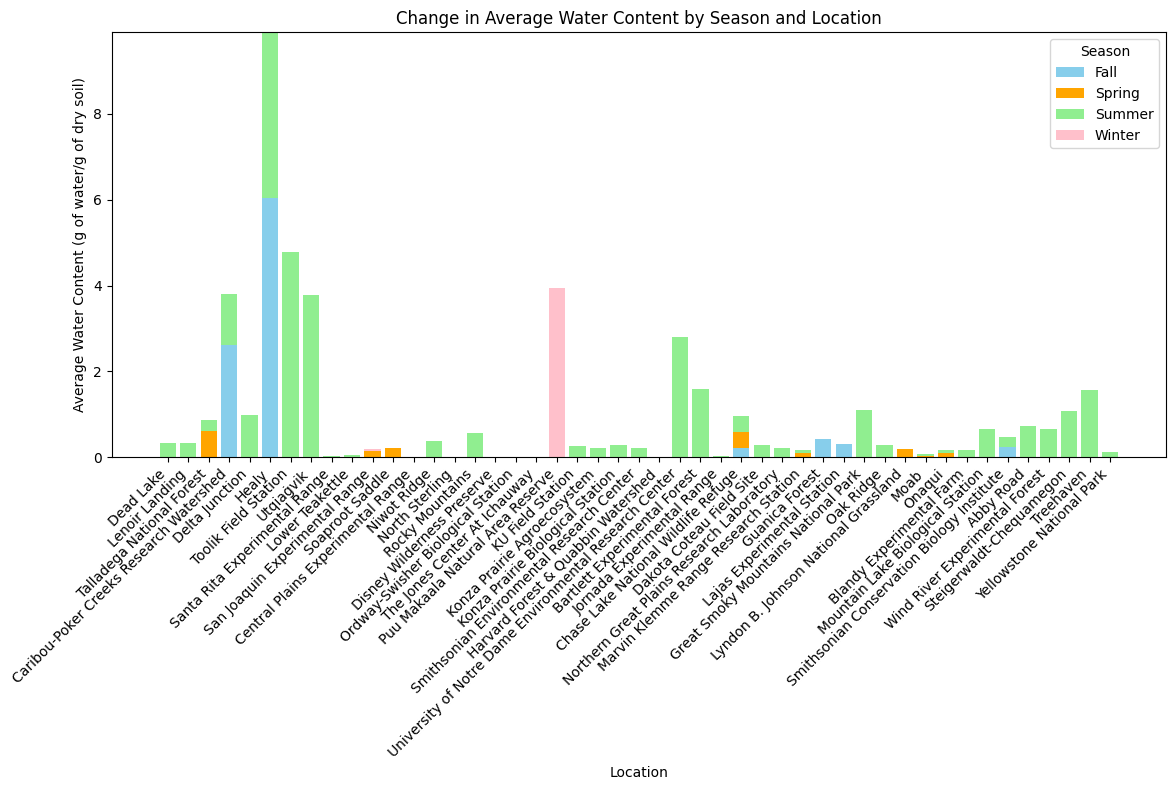

In [13]:
# Ensure 'collection_date' is in datetime format
df["collection_date"] = pd.to_datetime(df["collection_date"])
df["month"] = df["collection_date"].dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df["season"] = df["month"].apply(get_season)

# Group by location and season, then calculate mean water_content
grouped = df.groupby(['location', 'season'])['water_content'].mean().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))  # Adjusted for a taller plot

# Locations for the bars on the x-axis
ind = np.arange(len(grouped))

# Bottom for the stacking
bottom = np.zeros(len(grouped))

seasons = grouped.columns
colors = ['skyblue', 'orange', 'lightgreen', 'pink']  # Colors for each season
for season, color in zip(seasons, colors):
    ax.bar(ind, grouped[season], bottom=bottom, label=season, color=color)
    bottom += grouped[season]

# Modify x-axis labels to only include text after the last comma
# Split each index by comma, take the last part, and join back into a string if needed
new_labels = [label.split(',')[-1].strip() for label in grouped.index]

ax.set_title('Change in Average Water Content by Season and Location')
ax.set_xticks(ind)
ax.set_xticklabels(new_labels, rotation=45, ha="right")
ax.set_ylabel('Average Water Content (g of water/g of dry soil)')
ax.set_xlabel('Location')

ax.legend(title='Season')

plt.tight_layout()
plt.show()